In [51]:
import os 

# 가상 환경에서 발생하는 라이브러리 중복 로드 문제 해결
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [52]:
# 기본 라이브러리 및 PyTorch 관련 모듈 불러오기
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

In [53]:
# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)

In [54]:
# 메타데이터를 불러와 특정 배터리를 선택
DATA_ROOT = Path("cleaned_dataset")
META_PATH = DATA_ROOT / "metadata.csv"

meta = pd.read_csv(META_PATH)

battery_id = "B0006"

# 선택한 배터리 id에 해당하는 discharge type 데이터 필터링 및 정렬
battery_meta = (
    meta[(meta["type"] == "discharge") & (meta["battery_id"] == battery_id)]
    .sort_values("start_time")
    .reset_index(drop=True)
)

# Capacity 열을 숫자형으로 변환하고 사이클 인덱스 및 soh 열 추가
battery_meta["Capacity"] = pd.to_numeric(battery_meta["Capacity"], errors="coerce")
battery_meta["cycle_index"] = np.arange(len(battery_meta))
battery_meta["soh"] = battery_meta["Capacity"] / battery_meta["Capacity"].iloc[0]

display(battery_meta[["type", "cycle_index", "soh"]].head())
print(f"사이클 수: {len(battery_meta)}")

,type,cycle_index,soh
0,discharge,0,1.000000
1,discharge,1,1.057732
2,discharge,2,1.052433
3,discharge,3,0.964158
4,discharge,4,0.933925


사이클 수: 168


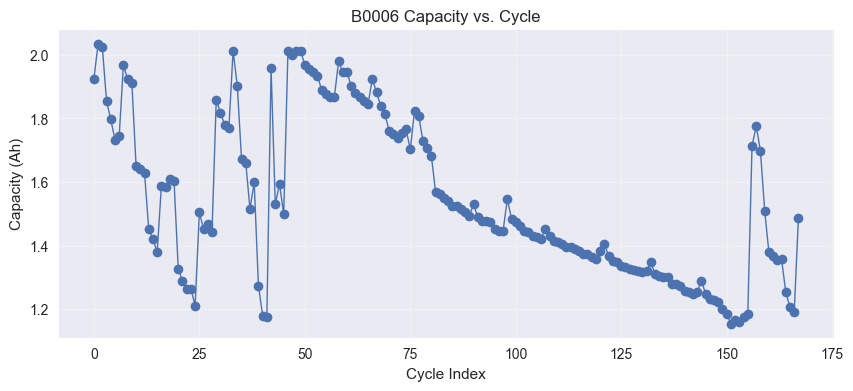

In [55]:
# 용량 감소 추이를 시각화하여 노화 패턴 확인
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(battery_meta["cycle_index"], battery_meta["Capacity"], marker="o", linewidth=1)
ax.set_xlabel("Cycle Index")
ax.set_ylabel("Capacity (Ah)")
ax.set_title(f"{battery_id} Capacity vs. Cycle")
ax.grid(True, alpha=0.3)
plt.show()

In [56]:
# 시퀀스 길이 최소 최대
lengths = []
for filename in battery_meta["filename"]:
    df = pd.read_csv(DATA_ROOT / "data" / filename)
    lengths.append(len(df))
print(f"원본 시퀀스 길이 최소: {np.min(lengths)}, 최대: {np.max(lengths)}")

원본 시퀀스 길이 최소: 179, 최대: 371


In [57]:
# 각 방전 사이클을 균일한 길이로 보간하는 함수 정의
SEQ_LEN = 179 # 최소 시퀀스 길이
FEATURE_COLS = [
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Current_load",
    "Voltage_load",
]

def load_cycle_sequence(filename: str, seq_len: int = SEQ_LEN) -> np.ndarray:
    """
        원본 csv마다 측정 시간이 다르기 때문에 SEQ_LEN 길이로 리샘플링
        -> 고정 길이 텐서로 맞춰주기 위함
    """
    path = DATA_ROOT / "data" / filename
    df = pd.read_csv(path).sort_values("Time")
    time = df["Time"].values
    new_time = np.linspace(time.min(), time.max(), seq_len)
    interpolated = []
    for col in FEATURE_COLS:
        interpolated.append(np.interp(new_time, time, df[col].values))
    return np.stack(interpolated, axis=1)

In [58]:
# # cycle_index = 0 일 때, 각 FEATURE_COLS 별 변화 시각화(그래프를 각각 출력)
# cycle_0_filename = battery_meta.loc[0, "filename"]
# cycle_0_data = load_cycle_sequence(cycle_0_filename)
# time_axis = np.linspace(0, 1, SEQ_LEN)
# for i, col in enumerate(FEATURE_COLS):
#     fig, ax = plt.subplots(figsize=(10, 4))
#     ax.plot(time_axis, cycle_0_data[:, i], marker="o", linewidth=1)
#     ax.set_xlabel("Normalized Time")
#     ax.set_ylabel(col)
#     ax.set_title(f"{battery_id} Cycle 0 - {col} vs. Time")
#     ax.grid(True, alpha=0.3)
#     plt.show()

In [59]:
# 선택한 배터리의 모든 방전 사이클을 시퀀스로 변환
sequences = np.stack(
    [load_cycle_sequence(fn) for fn in battery_meta["filename"]], axis=0
)

targets = battery_meta["soh"].values
print(f"시퀀스 데이터의 형태: {sequences.shape}")
print(f"타겟 데이터의 형태: {targets.shape}")

시퀀스 데이터의 형태: (168, 179, 5)
타겟 데이터의 형태: (168,)


In [60]:
# 시퀀스를 학습/검증 세트로 분할하고 정규화 수행
# 데이터를 N개의 구간으로 나누어 각 구간에서 8:2 비율로 학습/검증 데이터 추출
N_SPLITS = 1  # 데이터를 나눌 구간 수
train_ratio = 0.8
total_cycles = len(sequences)
split_size = total_cycles // N_SPLITS

train_indices = []
val_indices = []

for i in range(N_SPLITS):
    start_idx = i * split_size
    # 마지막 구간은 남은 모든 데이터를 포함
    if i < N_SPLITS - 1:
        end_idx = (i + 1) * split_size
    else:
        end_idx = total_cycles
    
    segment_indices = np.arange(start_idx, end_idx)
    
    # 현재 구간을 8:2로 분할
    segment_train_size = int(len(segment_indices) * train_ratio)
    
    train_indices.extend(segment_indices[:segment_train_size])
    val_indices.extend(segment_indices[segment_train_size:])

# 인덱스를 사용하여 데이터 분할
train_meta = battery_meta.iloc[train_indices].copy()
val_meta = battery_meta.iloc[val_indices].copy()

train_X = sequences[train_indices]
val_X = sequences[val_indices]

train_y = targets[train_indices]
val_y = targets[val_indices]

# 정규화는 학습 데이터 기준으로만 수행
flat_train = train_X.reshape(-1, len(FEATURE_COLS))
mean = flat_train.mean(axis=0)
std = flat_train.std(axis=0) + 1e-6

train_X_norm = ((train_X - mean) / std).astype(np.float32)
val_X_norm = ((val_X - mean) / std).astype(np.float32)

normalizer = {"mean": mean, "std": std, "features": FEATURE_COLS}

print("정규화 평균:", mean)
print("정규화 표준편차:", std)

print("정규화된 학습 시퀀스 형태:", train_X_norm.shape)
print("정규화된 검증 시퀀스 형태:", val_X_norm.shape)

정규화 평균: [ 3.47366094 -1.81300431 32.67337185  0.8901962   2.32833407]
정규화 표준편차: [0.24918911 0.59320926 4.04961231 1.67495981 0.79546364]
정규화된 학습 시퀀스 형태: (134, 179, 5)
정규화된 검증 시퀀스 형태: (34, 179, 5)


In [61]:
# PyTorch Dataset과 DataLoader 정의
class CycleDataset(Dataset):
    def __init__(self, sequences: np.ndarray, targets: np.ndarray):
        self.x = torch.from_numpy(sequences)
        self.y = torch.from_numpy(targets)

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

train_dataset = CycleDataset(train_X_norm, train_y.astype(np.float32))
val_dataset = CycleDataset(val_X_norm, val_y.astype(np.float32))

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataset), len(val_dataset)

(134, 34)

In [62]:
# LSTM 회귀 모델 정의
class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, (hn, _) = self.lstm(x)
        last_hidden = hn[-1]
        prediction = self.fc(last_hidden)
        return prediction.squeeze(-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMRegressor(input_size=len(FEATURE_COLS)).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 25

model

LSTMRegressor(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [63]:
# LSTM 모델 학습 루프
history = {"train_loss": [], "val_loss": []}
best_val = float("inf")
best_state = None

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)

    val_loss /= len(val_dataset)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    if val_loss < best_val:
        best_val = val_loss
        best_state = model.state_dict()

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"가장 낮은 검증 손실: {best_val:.4f}")


Epoch 01 | Train Loss: 0.6521 | Val Loss: 0.0737
Epoch 05 | Train Loss: 0.0054 | Val Loss: 0.0026
Epoch 10 | Train Loss: 0.0013 | Val Loss: 0.0002
Epoch 15 | Train Loss: 0.0009 | Val Loss: 0.0003
Epoch 20 | Train Loss: 0.0008 | Val Loss: 0.0002
Epoch 25 | Train Loss: 0.0008 | Val Loss: 0.0002
가장 낮은 검증 손실: 0.0002


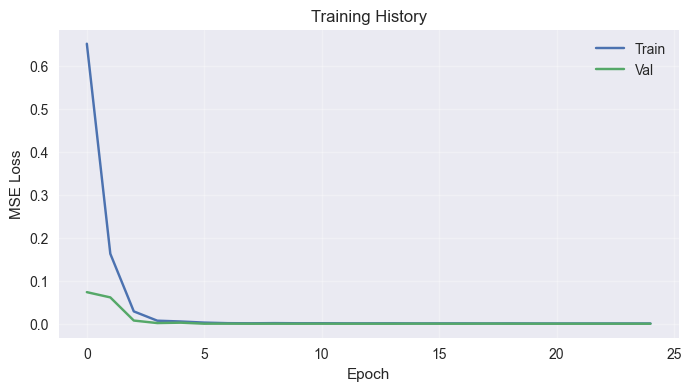

In [64]:
# 학습 및 검증 손실 곡선 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history["train_loss"], label="Train")
ax.plot(history["val_loss"], label="Val")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
ax.set_title("Training History")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()


In [65]:
# 검증 세트에 대한 예측 및 지표 계산
from sklearn.metrics import r2_score
model.eval()

def predict_dataset(loader: DataLoader):
    preds = []
    targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds_batch = model(xb).cpu().numpy()
            preds.append(preds_batch)
            targets.append(yb.numpy())
    return np.concatenate(preds), np.concatenate(targets)

val_preds, val_targets = predict_dataset(val_loader)

val_mae = np.mean(np.abs(val_preds - val_targets))
val_rmse = np.sqrt(np.mean((val_preds - val_targets) ** 2))

print(f"검증 MAE: {val_mae:.3f}")
print(f"검증 RMSE: {val_rmse:.3f}")
print(f"검증 R2 Score: {r2_score(val_targets, val_preds):.3f}")

검증 MAE: 0.010
검증 RMSE: 0.013
검증 R2 Score: 0.973


In [66]:
# 예측 결과를 메타데이터와 결합하여 확인
val_results = val_meta.copy()
val_results = val_results.assign(
    pred_soh=val_preds,
    true_soh=val_targets,
    error=val_preds - val_targets,
)

val_results.loc[:, ["cycle_index", "Capacity", "soh", "pred_soh", "error"]]

,cycle_index,Capacity,soh,pred_soh,error
134,134,1.305216,0.678300,0.663392,-0.014908
135,135,1.300406,0.675800,0.675267,-0.000533
136,136,1.300236,0.675712,0.672409,-0.003303
137,137,1.279253,0.664807,0.656607,-0.008201
138,138,1.279208,0.664784,0.648433,-0.016351
139,139,1.274037,0.662097,0.656944,-0.005152
140,140,1.258137,0.653834,0.635333,-0.018501
141,141,1.253260,0.651299,0.638583,-0.012716
142,142,1.248087,0.648611,0.638990,-0.009621
143,143,1.253435,0.651390,0.634458,-0.016932


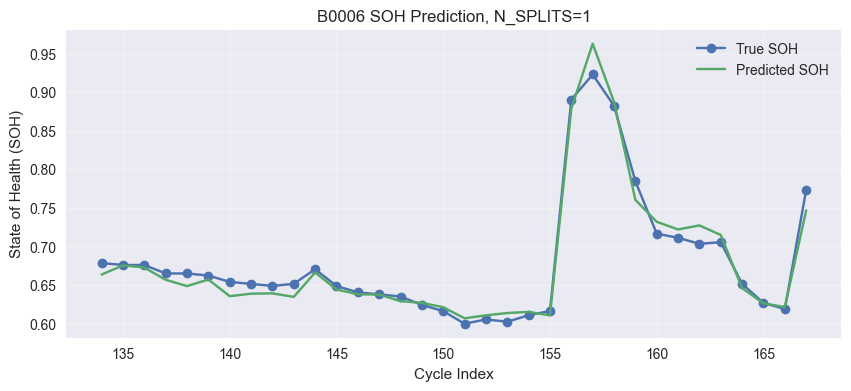

In [67]:
# 실제 SOH와 예측된 SOH 비교 시각화
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(val_results["cycle_index"], val_results["soh"], label="True SOH", marker="o")
ax.plot(val_results["cycle_index"], val_results["pred_soh"], label="Predicted SOH", marker="x")
ax.set_xlabel("Cycle Index")
ax.set_ylabel("State of Health (SOH)")
ax.set_title(f"{battery_id} SOH Prediction, N_SPLITS={N_SPLITS}")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()